In [12]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit, vmap, grad
import jax.random as random
rng = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree
from jax.scipy.optimize import minimize


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
cm = sns.color_palette("mako_r", as_cmap=True)
from scipy.stats import gaussian_kde
from scipy.stats import gamma, lognorm
import pandas as pd

In [13]:
murine_data = pd.read_csv('data/allmurinedata_numeric.csv')
# remove repetitive samples from the same region of a subject
murine_data = murine_data[murine_data['sample']==1]

# # Trim the first point of each curve where lm1,lm2=(1,1)
murine_data = murine_data[murine_data['lm11'] > 1.0]
murine_data = murine_data[murine_data['lm22'] > 1.0]

# # Reduce the data. Only keep one fourth of the points
# murine_data = murine_data[::4]

# shift the initial point of the stretches to (1,1)
for ID in np.unique(murine_data['ID']):
    for test in [0,1,2]:
        cond = (murine_data['ID']==ID) & (murine_data['test']==test)
        delta1 = murine_data['lm11'][cond].to_numpy()[0] - 1.0
        delta2 = murine_data['lm22'][cond].to_numpy()[0] - 1.0

        murine_data.loc[cond, 'lm11'] = murine_data['lm11'][cond] - delta1
        murine_data.loc[cond, 'lm22'] = murine_data['lm22'][cond] - delta2

        delta3 = murine_data['sigma11 (MPa)'][cond].to_numpy()[0] 
        delta4 = murine_data['sigma22 (MPa)'][cond].to_numpy()[0]

        murine_data.loc[cond, 'sigma11 (MPa)'] = murine_data['sigma11 (MPa)'][cond] - delta3
        murine_data.loc[cond, 'sigma22 (MPa)'] = murine_data['sigma22 (MPa)'][cond] - delta4

# Reassign ID so that there are no gaps
cur_ids = np.unique(murine_data['ID'])
new_ids = np.arange(len(cur_ids))
for i, ID in enumerate(cur_ids):
    murine_data.loc[murine_data['ID']==ID, 'ID'] = new_ids[i]
J = np.max(np.unique(murine_data.ID))


# Reduce the number of data points by prioritizing higher stretches
def reduce_rows(df, stretch_column_1, stretch_column_2, keep_ratio):
    df_sorted = df.sort_values([stretch_column_1, stretch_column_2])
    num_rows = len(df_sorted)
    indices_to_keep = [df_sorted.index[0]] #Always keep the first point
    for i, row in df_sorted.iterrows():
        stretch_1 = row[stretch_column_1]
        stretch_2 = row[stretch_column_2]
        keep_prob = np.exp(keep_ratio * (stretch_1 + stretch_2 - 2.0))-1.0
        if np.random.uniform() < keep_prob:
            indices_to_keep.append(i)
    return df.loc[indices_to_keep]

keep_ratio = 1.2
murine_data = murine_data.groupby(['ID', 'test']).apply(reduce_rows, 'lm11', 'lm22', keep_ratio).reset_index(drop=True)
murine_data

,ID,subject,age,region,sample,test,lm11,lm22,sigma11 (MPa),sigma22 (MPa)
0,0,0,0,0,1,0,1.000000,1.000000,0.000000,0.000000
1,0,0,0,0,1,0,1.011121,1.024513,0.002064,0.001145
2,0,0,0,0,1,0,1.015039,1.038004,0.002424,0.002035
3,0,0,0,0,1,0,1.021914,1.056122,0.002876,0.002365
4,0,0,0,0,1,0,1.044356,1.099926,0.003674,0.003444
...,...,...,...,...,...,...,...,...,...,...
1654,15,9,1,1,1,2,1.195880,1.306829,0.011327,0.008167
1655,15,9,1,1,1,2,1.201219,1.314198,0.011613,0.008288
1656,15,9,1,1,1,2,1.206527,1.322457,0.011903,0.008508
1657,15,9,1,1,1,2,1.211512,1.327753,0.012253,0.008688


In [61]:
def goh(par,lam1,lam2):
    mu = par[0]
    k1 = par[1]
    k2 = par[2]
    kappa = par[3]
    alpha = par[4]
    mu = jnp.exp(mu)
    k1 = jnp.exp(k1)
    k2 = jnp.exp(k2)
    kappa = jnp.exp(kappa)
    
    #Structure tensor
    a0 = jnp.array([jnp.cos(alpha),jnp.sin(alpha),0])
    A0 = jnp.outer(a0,a0)
    
    #Kinematics
    lam3 = 1.0/(lam1*lam2)
    F = jnp.array([[lam1 ,0., 0],
                   [0., lam2, 0] ,
                   [0., 0, lam3]])
    C = F.T @ F
    invC = jnp.linalg.inv(C)
    I = jnp.eye(3)
    
    #Invariants
    I1 = C[0,0] + C[1,1] + C[2,2]
    I4 = jnp.tensordot(C,A0)
    
    
    #Evaluate stress
    H = kappa*I1+(1-3*kappa)*I4
    E = H-1
    S2 = mu*I+2*k1*jnp.exp(k2*E**2)*E*(kappa*I+(1-3*kappa)*A0)
    p = S2[2,2]/invC[2,2] #Get pressure  by equating S_33=0
    S = -p*invC+S2

    sgm =  F @ (S @ F.T)
    return sgm[0,0], sgm[1,1]
goh_vmap = vmap(goh, in_axes=(None,0,0), out_axes=(0,0))

In [83]:
i = 2
lmbx_gt = murine_data[murine_data.ID==i]['lm11'].to_numpy()
lmby_gt = murine_data[murine_data.ID==i]['lm22'].to_numpy()
sgmx_gt = murine_data[murine_data.ID==i]['sigma11 (MPa)'].to_numpy()
sgmy_gt = murine_data[murine_data.ID==i]['sigma22 (MPa)'].to_numpy()
def loss(params):
    sgmx_pr, sgmy_pr = goh_vmap(params, lmbx_gt, lmby_gt)
    return np.mean((sgmx_pr-sgmx_gt)**2 + (sgmy_pr-sgmy_gt)**2)

In [88]:
params = jnp.array([-4.66133822,  1.31487684,  1.34951576, -0.93474037,  0.89686985]) #Intial guess for the optimizer
out = minimize(loss, params, method='BFGS')
out.x

Array([-4.66133822,  1.31487684,  1.34951576, -0.93474037,  0.89686985],      dtype=float64)

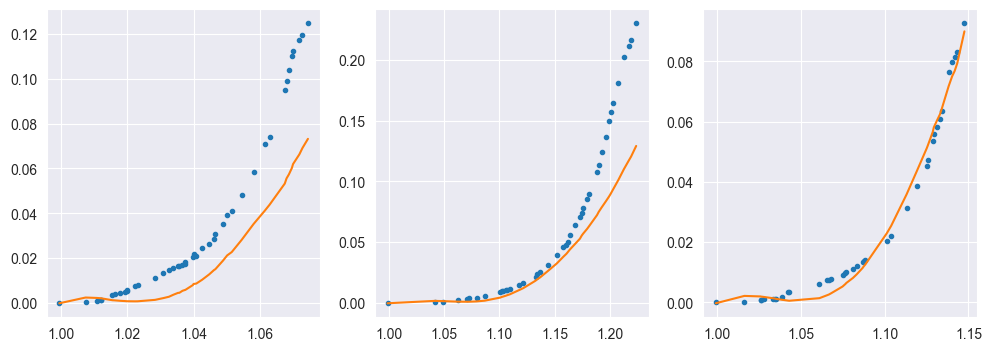

In [89]:
sgmx_pr, sgmy_pr = goh_vmap(out.x, lmbx_gt, lmby_gt)

fig, ax = plt.subplots(1,3,figsize=(12,4))
for t in range(3):
    lmbx_gt = murine_data[(murine_data.ID==i)&(murine_data.test==t)]['lm11'].to_numpy()
    lmby_gt = murine_data[(murine_data.ID==i)&(murine_data.test==t)]['lm22'].to_numpy()
    sgmx_gt = murine_data[(murine_data.ID==i)&(murine_data.test==t)]['sigma11 (MPa)'].to_numpy()
    sgmy_gt = murine_data[(murine_data.ID==i)&(murine_data.test==t)]['sigma22 (MPa)'].to_numpy()
    
    sgmx_pr, sgmy_pr = goh_vmap(out.x, lmbx_gt, lmby_gt)

    ax[t].plot(lmbx_gt, sgmx_gt, '.')
    ax[t].plot(lmbx_gt, sgmx_pr)